In [56]:
# !pip install langgraph langchain_ollama 
!pip install -qU duckduckgo-search langchain-community


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from langchain_ollama import ChatOllama
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import ToolNode
search = DuckDuckGoSearchRun()


llm = ChatOllama(model="jacob-ebey/phi4-tools:latest")
# llm = ChatOllama(model="qwen2.5:32b")
# llm = ChatOllama(model="MFDoom/deepseek-r1-tool-calling:32b")

system = '''You are an AI assistant that follows a ReAct (Reasoning + Acting) framework to answer questions efficiently using search. You will think step by step, take appropriate actions, and provide observations before concluding with an answer. Follow the format strictly:

Format:
Question: The question asked.
Thought: Reason logically about how to find the answer.
Action: Choose an action. If search is needed, use Search[query]. If an answer is found, use Finish[answer].
Observation: The result of the action.
Repeat steps until the answer is found.
Example 1:
Question: What profession does Nicholas Ray and Elia Kazan have in common?
Thought 1: I need to search Nicholas Ray and Elia Kazan, find their professions, then find the profession they have in common.
Action 1: Search[Nicholas Ray]
Observation 1: Nicholas Ray (born Raymond Nicholas Kienzle Jr., August 7, 1911 - June 16, 1979) was an American film director, screenwriter, and actor best known for the 1955 film Rebel Without a Cause.
Thought 2: Professions of Nicholas Ray are director, screenwriter, and actor. I need to search Elia Kazan next and find his professions.
Action 2: Search[Elia Kazan]
Observation 2: Elia Kazan was an American film and theatre director, producer, screenwriter, and actor.
Thought 3: Professions of Elia Kazan are director, producer, screenwriter, and actor. So the profession Nicholas Ray and Elia Kazan have in common is director, screenwriter, and actor.
Action 3: Finish[director, screenwriter, actor]

Example 2:
Question: Which magazine was started first, Arthur’s Magazine or First for Women?
Thought 1: I need to search Arthur’s Magazine and First for Women, and find which was started first.
Action 1: Search[Arthur’s Magazine]
Observation 1: Arthur’s Magazine (1844-1846) was an American literary periodical published in Philadelphia in the 19th century.
Thought 2: Arthur’s Magazine was started in 1844. I need to search First for Women next.
Action 2: Search[First for Women]
Observation 2: First for Women is a women’s magazine published by Bauer Media Group in the USA. The magazine was started in 1989.
Thought 3: First for Women was started in 1989. Since 1844 (Arthur’s Magazine) < 1989 (First for Women), Arthur’s Magazine was started first.
Action 3: Finish[Arthur’s Magazine]

Follow this process for all questions. Do not assume answers without searching. Always reason through each step before deciding on an action. and output only '''

tools = [search]
toolLLMNode = llm.bind_tools(tools)
toolNode = ToolNode(tools,)

In [10]:
toolLLMNode.invoke("what is the current news in delhi right now")

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'jacob-ebey/phi4-tools:latest', 'created_at': '2025-02-17T08:35:13.550569866Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3566040160, 'load_duration': 2903946446, 'prompt_eval_count': 182, 'prompt_eval_duration': 202000000, 'eval_count': 34, 'eval_duration': 459000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-6b110cef-76d4-49fe-8014-045070929094-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'current news in Delhi'}, 'id': '4faef0d6-50c1-492b-bbce-4e0168c46cfc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 182, 'output_tokens': 34, 'total_tokens': 216})

In [11]:
t = toolNode.invoke({"messages": [toolLLMNode.invoke("who is winning the elections in delhi right now?")]})
t["messages"][-1].content

"The results of Delhi Assembly Election 2025 are out and clear. The Bharatiya Janata Party swept 48 seats out of 70. The exit polls during the elections on February 5, 2025 suggested a vote in favour of the BJP and their consequent return after more than two decades. Also read: Delhi election results 2025 LIVE The BJP has been out of office in Delhi since 1998. On the other hand, AAP has dominated Delhi's political landscape for the past 10 years, winning ... Delhi Election Results 2025 Constituency-wise: The BJP is set to form a government in Delhi after more than 26 years, with the latest trends showing the saffron party ahead in 47 of the 70 assembly seats and AAP in 23. AAP supremo Arvind Kejriwal lost to the BJP's Parvesh Verma in the high-profile New Delhi seat. Former deputy chief minister and senior AAP leader Manish Sisodia conceded ... Delhi Election Results 2025: List of all winners, party, votes, and majority Here is all the winners of Delhi Assembly Elections 2025 held on 

In [12]:
from typing import Sequence
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated,Literal,List,Union,Dict

class ExperimentProcedure(BaseModel):
    procedure: Dict[str, Union[List[str], Dict[str, List[str]]]] = Field(..., description="Detailed procedure steps categorized by type")

class Json_output(BaseModel):
    title: str = Field(..., description="Title of the experiment")
    objective: str = Field(..., description="Objective or purpose of the experiment")
    materials: List[str] = Field(..., description="List of materials required for the experiment")
    procedure: ExperimentProcedure = Field(..., description="Step-by-step experimental procedure")
    
class State(TypedDict):
    input: str
    intermediate_steps : Annotated[list,operator.add]
    final_result: str
    system_prompt: str
    iteration:int

    




class Action(BaseModel):
    # reason: str = Field(description="the input of the user and how do you reason the decision")
    reason: str=Field(description="which decision was chosen and why based on the action") 
    decision: Literal["Finish", "ToolCall"] = Field(description="the action to be chosen by evaluating the thought process. if the input is undecisive then call ToolCall otherwise Finish")
actionLLM = llm.with_structured_output(Action,method="json_schema")
generator = llm.with_structured_output(Json_output,method='json_schema')

In [13]:
resp = actionLLM.invoke("i now have complete information now i can rest")

In [14]:
if resp.decision == "ToolCall":
    print("yess")

yess


In [22]:
def thinking_llm(state:State):
    if state["iteration"] !=0:
        resp = llm.invoke(f"Analyze the situation step by step based on the following context: {state['intermediate_steps']}. Clearly reason through each step and output the what do you need to do in order to perform the lab activity safely you have the access to web search if needed use that by asking that you need to search the web for the so and so.\n \n Thought {state['iteration']} :" )
        fs = state["intermediate_steps"] + [f"Thought {state['iteration']}"+ resp.content]
        state.update({"intermediate_steps": fs})
        state.update({"iteration":state["iteration"]+1})
        
        return state
    else :
        resp = llm.invoke(f"given system_prompt [{state['system_prompt']}] and input {state['input']} output the thought. \n\n Thought {state['iteration']} :")
        fs = state["intermediate_steps"] + [f"Thought {state['iteration']}"+ resp.content]
        state.update({"intermediate_steps": fs})
        state.update({"iteration":state["iteration"]+1})
        # print("thinking...")
        return state

def action_llm(state:State):
    resp = actionLLM.invoke(f"based on the following thought process should the model be calling a ToolCall or if the model has all information then it should call Finish. Based on the input {state['intermediate_steps'][-1]}")
    fs = state["intermediate_steps"] + [f"Action {state['iteration']}"+ resp.reason]
    state.update({"intermediate_steps": fs})
    # state.update({"iteration":state["iteration"]+1})
    if resp.decision == "Finish":
        # print("choosing action to finish")
        return "Finishing"
    elif resp.decision == "ToolCall":
        # print("choosing action to use Tools")
        return "Finishing"
    
def finishingNode(state:State):
    resp = llm.invoke(f"based on '{state['input']}' which is the user prompt and the LLMs Thought process [{state['intermediate_steps']}] generate a final response for the input prompt using the information from Thought Process.")
    # fs = state["intermediate_steps"] + [resp.content]
    state.update({"final_result": [resp.content]})
    # print("finished!")
    return state

def toolingLLMNode(state:State):

    resp = toolLLMNode.invoke(f'based on {str(state["intermediate_steps"][-2:])} call the appropriate tool')
    respToTool = toolNode.invoke({"messages":[resp]})
    fs = state["intermediate_steps"] + [f"observation {state['iteration']}: "+respToTool["messages"][-1].content]
    state.update({"intermediate_steps": fs})
    # print("running Tool")
    return state

In [23]:
from langgraph.graph import StateGraph,START,END
build = StateGraph(State)
build.add_node("ToolDecidingNode",toolingLLMNode)
# build.add_node("ToolNode",toolNode)
build.add_node("ThoughtNode",thinking_llm)
# build.add_node("actionNode",action_llm)
build.add_node("final_node",finishingNode)

build.add_edge(START,"ThoughtNode")
# build.add_edge("ThoughtNode","actionNode")
# build.add_edge("ToolDecidingNode","ToolNode")
# build.add_edge("ThoughtNode",END)
build.add_edge("ToolDecidingNode", "ThoughtNode")
build.add_conditional_edges("ThoughtNode",action_llm,{"ToolNode":"ToolDecidingNode","Finishing":"final_node"})
build.add_edge("final_node",END)
# build.set_entry_point(START)
# build.set_finish_point(END)
# graph = build.compile()


In [24]:
experiment_name = [
    "To verify the relationship between voltage (V), current (I), and resistance (R) in an electrical circuit, as expressed by Ohm's Law: V=IRV = IRV=IR",
    "To apply Kirchhoff’s Voltage Law (KVL) and Kirchhoff’s Current Law (KCL) to analyze and validate simple electrical circuits.",
    "To study the behavior of resistors in series and parallel configurations, including the equivalent resistance calculation.",
    "To study the forward and reverse bias characteristics of a PN junction diode.",
    "To analyze voltage regulation using a Zener diode.",
    "To construct and analyze the performance of half-wave and full-wave rectifiers, both with and without filters.",
    "To analyze and implement wave-shaping circuits using diodes for clipping and clamping applications.",
    "To analyze the input and output characteristics of Bipolar Junction Transistors (BJTs) and Field-Effect Transistors (FETs).",
    "To design a common emitter amplifier and analyze its frequency response.",
    "To implement and analyze operational amplifier (Op-Amp) circuits: inverting, non-inverting, summing, and differentiator configurations.",
    "To verify the operation of basic logic gates: AND, OR, NOT, NAND, NOR, XOR, and XNOR",
    "To investigate the charging and discharging behavior of a capacitor in an RC circuit and understand the time constant.",
    "To investigate the resonance behavior of an LC circuit and measure the resonant frequency.",
    "To calibrate an oscilloscope for accurate measurements of voltage and time.",
    "To determine the turns ratio of a transformer and verify the relationship between the primary and secondary voltages.",
    "To construct and analyze a bridge rectifier circuit and compare its performance with a half-wave rectifier.",
    "To study the frequency response of a low-pass filter and determine its cutoff frequency.",
    "To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.",
    "To generate and analyze Lissajous figures using an oscilloscope by applying two sinusoidal signals with different frequencies.",
    "To study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength."
]

In [25]:
import copy
remaining_exp = copy.deepcopy(experiment_name[:6])

In [26]:
import json

# Read the input JSON file
# with open('experiments_generated_phi4.json', 'r') as file:
#     data = json.load(file)

# Function to format an experiment into the desired string
def format_experiment(experiment):
    exp_name = experiment["title"] if experiment['title'].find("Experiment Plan:")==-1 else experiment["title"].split("Experiment Plan:")[1]

    formatted = f"Experiment Name: {exp_name}\n\n"
    formatted += f"Objective: {experiment['objective']}\n\n"
    formatted += "Materials Required:\n"
    for i, material in enumerate(experiment['materials'], 1):
        formatted += f"{i}. {material}\n"
    
    # Handle procedure, analysis, etc.
    if 'procedure' in experiment:
        formatted += "\nStep-by-Step Procedure:\n"
        procedure = experiment['procedure']
        
        # Handle different procedure structures
        if isinstance(procedure, dict):
            for step, items in procedure.items():
                if isinstance(items, list):
                    for i, item in enumerate(items, 1):
                        formatted += f"{i}. {item}\n"
                elif isinstance(items, dict):
                    for sub_step, sub_items in items.items():
                        formatted += f"\n{sub_step}:\n"
                        for i, sub_item in enumerate(sub_items, 1):
                            formatted += f"{i}. {sub_item}\n"
    
    # Add other sections like analysis, expected results, and conclusion
    if 'analysis' in experiment:
        formatted += "\nAnalysis:\n"
        for i, analysis in enumerate(experiment['analysis'], 1):
            formatted += f"{i}. {analysis}\n"
    
    return formatted


In [19]:
from langgraph.checkpoint.memory import MemorySaver
from langchain.globals import set_debug, set_verbose
import pprint
# set_debug(True)
set_verbose(True)
memory = MemorySaver()
k = 0
counting = 0
graph = build.compile(checkpointer=memory)
config = {"configurable": {"thread_id": str(k)+str(counting)}}
remaining_exp = copy.deepcopy(experiment_name)
exp_name = remaining_exp.pop()
for event  in graph.stream({'input':f"plan the following experiment {{{exp_name}}} and ensure that the experiments are with in the safety parameters also ensure that the output contains items required and experiments steps",'intermediate_steps':[],'iteration':0},config=config):
    pprint.pp(event)
    # print(event)

thinking...


TypeError: can only concatenate list (not "str") to list

In [33]:
import ipywidgets as widgets
widgets.IntProgress(value=50, min=0, max=100, description="Loading:")

IntProgress(value=50, description='Loading:')

In [41]:
!pip uninstall tqdm


^C


In [44]:
from tqdm.notebook import tqdm as tqdm
import time

for i in tqdm(range(8, 10), desc="hi!"):
    for k in tqdm(range(10), leave=True):
        time.sleep(1)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [29]:
!!pip install -U ipywidgets jupyter

^C


[]

In [ ]:
from tqdm import tqdm
from langgraph.checkpoint.memory import MemorySaver
import json
# from tqdm import tqdm
from langchain.globals import set_debug, set_verbose

# set_debug(True)
# set_verbose(True)
for k in tqdm(range(10),desc="Sample No: "):
    remaining_exp = copy.deepcopy(experiment_name)
    memory = MemorySaver()
    fname = f"phi4Outputs_"+str(k)
    counting = 1
    for i in tqdm(range(len(remaining_exp)),desc="experiment No",):
        graph = build.compile(checkpointer=memory)
        config = {"configurable": {"thread_id": str(k)+str(counting)}}
        exp_name = remaining_exp.pop()
        for event  in graph.stream({'input':f"plan the following experiment {{{exp_name}}} and ensure that the experiments are with in the safety parameters also ensure that the output contains items required and experiments steps",'intermediate_steps':[],'iteration':0,'system_prompt':system},config=config):
            if "final_node" in event:
                # print(counting)
                # with open("experiments_generated_phi4.txt",'a',encoding="utf-8") as F:
                #     F.write("\n---\n")
                #     F.write(f"# {counting} {exp_name}\n")
                #     F.write(event['final_node']['final_result'][0])
                json_output =event['final_node']['final_result'][0]
                if hasattr(json_output, "model_dump"):  # Check if it's a Pydantic model
                    json_output = json_output.model_dump()

                # Save as JSON
                # with open("experiments.json", "a", encoding="utf-8") as json_file:
                #     json.dump(json_output, json_file, indent=4)
                try:
                    with open("exps_phi4/"+fname+".json", "r", encoding="utf-8") as json_file:
                        existing_data = json.load(json_file)
                except (FileNotFoundError, json.JSONDecodeError):
                    existing_data = {"experiments": []}  # Default structure if file is empty or missing

                # Append new experiment data
                existing_data["experiments"].append(json_output)

    # Save back to the file
                with open("exps_phi4/"+fname+".json", "w", encoding="utf-8") as json_file:
                    json.dump(existing_data, json_file, indent=4)
                with open("exps_phi4/"+fname+".md",'a',encoding="utf-8") as F:
                    F.write("\n---\n")
                    F.write(f"# {counting} {exp_name}\n")
                    F.write(event['final_node']['intermediate_steps'][0])
                    # print(event['final_node']['intermediate_steps'])
                counting+=1

    with open("exps_phi4/"+fname+'.json', 'r') as file:
        data = json.load(file)
    new_data = {}
    reveresed_exps = experiment_name[::-1]
    # for no,experiment in enumerate(data['experiments']):
    #     new_data[reveresed_exps[no]] = format_experiment(experiment)

    # # Write the new data to a JSON file
    # with open("formatted_exps_phi4/"+fname+'
    # 
    # 
    # .json', 'w') as file:
    #     json.dump(new_data, file, indent=2)
    
























































































experiment No: 100%|██████████| 20/20 [09:29<00:00, 28.46s/it]























































































experiment No: 100%|██████████| 20/20 [07:35<00:00, 22.77s/it]























































































experiment No: 100%|██████████| 20/20 [07:54<00:00, 23.73s/it]























































































experiment No: 100%|██████████| 20/20 [07:44<00:00, 23.21s/it]























































































experiment No: 100%|██████████| 20/20 [07:16<00:00, 21.83s/it]























































































experiment No: 100%|██████████| 20/20 [07:52<00:00, 23.61s/it]























































































experiment No

In [50]:
import os

def list_files_in_directory(directory):
    try:
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")

# Replace 'your_directory_path' with the path of the directory you want to list
directory_path = 'd:/python/agents/formatted_exps'
save_path = 'd:/python/agents/reformatted_exps'
exps = list_files_in_directory(directory_path)
for file in exps:
    new_data = {}
    with open(directory_path+"/"+file,'r') as f:
        data = json.load(f)
        exps_list= experiment_name[::-1]
        for no,key in enumerate(data.keys()):
            new_data[exps_list[no]]= data[key]
    with open(save_path+"/"+file,'w') as F:
        json.dump(new_data,F,indent=2)
    


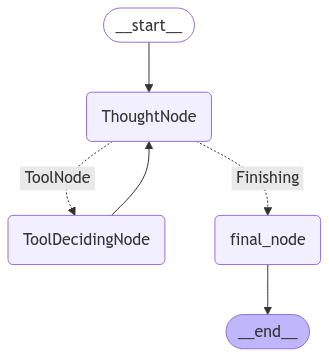

In [59]:
# graph = build.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Evaluation

In [67]:
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated
from langchain_ollama import ChatOllama
from langgraph.graph import START, MessagesState, StateGraph,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from typing import Union, Dict

formatter_llm = ChatOllama(model="jacob-ebey/phi4-tools:latest")
class score(BaseModel):
    score1: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 1")
    score2: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 2")
    score3: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 3")
    score4: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 4")
    score5: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 5")

class JsonnedOutput(BaseModel):
    Accuracy: score = Field(...,description="ratings of the Accuracy in a probabilstic distribution manner")
    Completeness: score = Field(...,description="ratings of the Completeness in a probabilstic distribution manner")
    Clarity: score = Field(...,description="ratings of the Clarity in a probabilstic distribution manner")
    Safety:score = Field(...,description="ratings of the Safety in a probabilstic distribution manner")

def generate_evaluation_prompt(ground_truth: Dict, test_procedure: str) -> str:
    return f"""
        You are an expert evaluator assessing the accuracy, completeness, clarity, and safety of a scientific experiment procedure.

        ### **Task**
        Compare the **Test Procedure** against the **Ground Truth** and evaluate it across four key dimensions. Provide a **probability distribution over scores [1,2,3,4,5]** for each category.

        ### **Evaluation Criteria**
        1. **Accuracy**: Are the components and steps correct?
        2. **Completeness**: Are all critical steps present?
        3. **Clarity**: Is the procedure easy to follow?
        4. **Safety**: Are safety precautions included?

        ### **Response Format (Strict JSON)**
        ```json
        {{
            "Accuracy": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Completeness": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Clarity": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Safety": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }}
        }}
        Each probability value must be between 0 and 1 and sum to 1.

        ### **Ground Truth**
        {json.dumps(ground_truth, indent=4)}

        ### **Test Procedure**
        {test_procedure}
        """

formatter = formatter_llm.with_structured_output(JsonnedOutput,method='json_mode')

In [68]:
class State(TypedDict):
    input: str
    output: Union[JsonnedOutput,None]

workflow = StateGraph(state_schema=State)
def generate_graph_evaluation(state:State):
    # print(state["input"])
    response = formatter_llm.invoke(state["input"])
    # print(response)
    formatted_response = formatter.invoke(f"based on the {response.content} only output probabilities of each criteria and Leave everything. OUTPUT in the following json manner {{'Accuracy': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Completeness': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Clarity': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }},'Safety': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }} }} but ensure that the json format is correct")
    print(formatted_response)
    return {"output":{"Accuracy": formatted_response.Accuracy, "Completeness": formatted_response.Completeness,"Clarity":formatted_response.Clarity,"Safety": formatted_response.Safety}}

workflow.add_node("evaluator",generate_graph_evaluation)
workflow.add_edge(START,"evaluator")
workflow.add_edge("evaluator",END)
eval_grapgh = workflow.compile()

In [69]:
from typing import Dict, Optional
def evaluate_experiment(title: str, ground_truth: Dict, test_procedure: str):
    prompt = generate_evaluation_prompt(ground_truth, test_procedure)


    for event in eval_grapgh.stream({"input": prompt, "output": None }):
        
    # Debug: Print the raw response to see what the model is returning
        try:
            return event['evaluator']['output']
        except KeyError:
            return event

    

In [70]:
import os

def list_files_in_directory(directory):
    try:
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")

In [72]:
import logging
import json
import re
import logging
from typing import Dict, Optional
from typing import TypedDict
import tqdm
# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")
# logger = logging.getLogger(__name__)

def load_json(filepath: str) -> Dict:
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        # logger.error(f"File not found: {filepath}")
        print("file not found")
        raise
    except json.JSONDecodeError:
        # logger.error(f"Invalid JSON in file: {filepath}")
        print("file not found")
        raise
def extract_json_from_response(response_text: str) -> Optional[Dict]:
    try:
        json_match = re.search(r"\{.*\}", response_text, re.DOTALL)  # Extracts only JSON part
        if json_match:
            return json.loads(json_match.group())
        else:
            # logger.error("No valid JSON found in response.")
            print("file not found")
            return None
    except json.JSONDecodeError as e:
        # logger.error(f"JSON parsing error: {e}")
        print("file not found")
        return None

# class Plots(TypedDict):
#     experiment: list=[]
#     'Accuracy': list
#     Clarity: list=[]
#     Completeness: list=[]
#     Safety: list=[]

def run_evaluation(ground_truth_path: str, results_path: str, output_path: str,plots:dict):
    ground_truth_data = load_json(ground_truth_path)
    llm_generated_results = load_json(results_path)["experiments"]
    print(llm_generated_results)
    ground_truth_dict = {exp["title"]: exp for exp in ground_truth_data["experiments"]}
    evaluation_results = {}
    rewards = {}
    for chosen_exps in llm_generated_results:
        for title,test_procedure in chosen_exps.items():
            ground_truth = ground_truth_dict.get(title)

            if ground_truth:
                # logger.info(f"Evaluating: {title}")
                result = evaluate_experiment(title, ground_truth, test_procedure)
                # logger.info(result["Accuracy"].score1)
                for key,values in result.items():
                    # values
                    # print(values.score1)
                    # print(values.score2)
                    # print(values.score3)
                    # print(values.score4)
                    # print(values.score5)
                    plots.update({str(key):plots[key]+[1*float(values.score1)+2*float(values.score2)+3*float(values.score3)+4*float(values.score4)+5*float(values.score5)]})
                # if result:
                #     evaluation_results[title] = result
                #     rewards[title] = calculate_reward(result)
    output_data = {
        "evaluations": evaluation_results,
        "rewards": rewards
    }
    with open(output_path, "w", encoding="utf-8") as file:
        json.dump(output_data, file, indent=4, ensure_ascii=False)

    # logger.info(f"Evaluation complete! Results saved to '{output_path}'.")
    return plots

exps = list_files_in_directory('d:/python/agents/reformatted_phi4_exps')
samples_plot = []
for evaluations in tqdm.tqdm(exps,desc="sample No"):
    plots = {'Accuracy':[],'Clarity':[],'Completeness':[],'Safety':[]}
    samples_plot.append(run_evaluation(
        ground_truth_path="experiments_2.json",
        results_path="reformatted_phi4_exps/"+evaluations,
        output_path="evaluation_results.json",
        plots=plots
    ))
    
    

[print(plotings) for plotings in samples_plot]




sample No:   0%|          | 0/10 [00:00<?, ?it/s]


[{'To study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength.': 'To design an experiment that constructs and analyzes the performance of both half-wave and full-wave rectifiers, with and without filters, while ensuring safety parameters are met, follow these detailed steps:\n\n### Materials Required:\n- **AC Power Supply:** A transformer to provide the necessary AC voltage.\n- **Diodes:** 1N4007 diodes for rectification.\n- **Resistors:** To act as load resistors in the circuit.\n- **Capacitors:** For filtering purposes, to smooth out the DC output.\n- **Breadboard or PCB:** For assembling the circuits.\n- **Connecting Wires:** To make connections between components.\n- **Multimeter:** For measuring voltage and current.\n\n### Safety Precautions:\n1. Use components with appropriate voltage ratings to prevent damage.\n2. Double-check all connections before powering the circuit to avoid short circuits.\n3. Utilize insulated

ConnectError: [WinError 10065] A socket operation was attempted to an unreachable host

In [16]:
import pprint
print(samples_plot)
with open("Phi4_20Exps.txt",'w') as F:
    F.write(str(samples_plot))

[{'Accuracy': [3.6, 3.6, 3.6, 3.6, 3.6, 3.8, 3.6, 3.6, 3.7, 3.6, 3.75, 3.6, 4.95, 3.7, 4.4, 3.6, 3.7, 3.6, 3.4, 3.7], 'Clarity': [3.9000000000000004, 2.95, 2.95, 3.9000000000000004, 3.15, 4.0, 3.9000000000000004, 3.6500000000000004, 3.8, 4.05, 4.199999999999999, 3.7, 4.95, 4.25, 4.15, 3.15, 4.0, 2.95, 4.75, 3.9000000000000004], 'Completeness': [4.05, 3.75, 4.05, 4.05, 4.05, 4.15, 4.05, 3.1999999999999997, 3.5, 3.95, 3.8499999999999996, 3.8, 4.9, 4.4, 4.3, 4.05, 3.6, 4.05, 4.75, 4.25], 'Safety': [3.5, 3.8, 3.8, 3.5, 3.95, 4.3, 4.3, 4.05, 4.3, 4.3, 4.25, 3.1999999999999997, 3.55, 3.9000000000000004, 3.0999999999999996, 3.9000000000000004, 4.3, 3.5999999999999996, 4.5, 3.5]}, {'Accuracy': [3.5, 3.6, 3.6, 3.5, 3.75, 3.7, 3.6, 3.6, 4.0, 3.0999999999999996, 3.4, 3.6, 3.5, 3.6, 3.5, 4.2, 4.1, 3.6, 3.75, 3.5], 'Clarity': [4.3, 3.9000000000000004, 3.15, 4.2, 4.2, 4.4, 3.9000000000000004, 3.8, 4.0, 3.9000000000000004, 4.4, 3.9000000000000004, 4.4, 3.9000000000000004, 4.1, 4.1, 4.7, 3.15, 4.3, 4.

In [33]:
exps = list_files_in_directory('d:/python/agents/ReActQwen')
with open("ReActQwen/"+exps[0],'r') as F:
    complete_exps = json.load(F)
    print(type(complete_exps['experiments'][0]))

<class 'dict'>


In [49]:
import ast

with open("phi4reactplots.txt", "r") as file:
    content = file.read()  # Read the file as a string
    data = ast.literal_eval(content)  # Convert string to a Python object

print(len(data))  # Now data is a list of dictionaries
# print(type(data))  # Should output <class 'list'>
phi4exp1_completeness = []
phi4exp2_completeness = []
phi4exp3_completeness = []
for i in data:
    # print(i['Completeness'])
    phi4exp1_completeness.append(i['Completeness'][0])
    phi4exp2_completeness.append(i['Completeness'][1])
    phi4exp3_completeness.append(i['Completeness'][2])

10


In [50]:
import ast

with open("qwennormalplot.txt", "r") as file:
    content = file.read()  # Read the file as a string
    data = ast.literal_eval(content)  # Convert string to a Python object

print(len(data))  # Now data is a list of dictionaries
# print(type(data))  # Should output <class 'list'>
qwenNexp1_completeness = []
qwenNexp2_completeness = []
qwenNexp3_completeness = []
for i in data:
    # print(i['Completeness'])
    qwenNexp1_completeness.append(i['Completeness'][0])
    qwenNexp2_completeness.append(i['Completeness'][1])
    qwenNexp3_completeness.append(i['Completeness'][2])

9


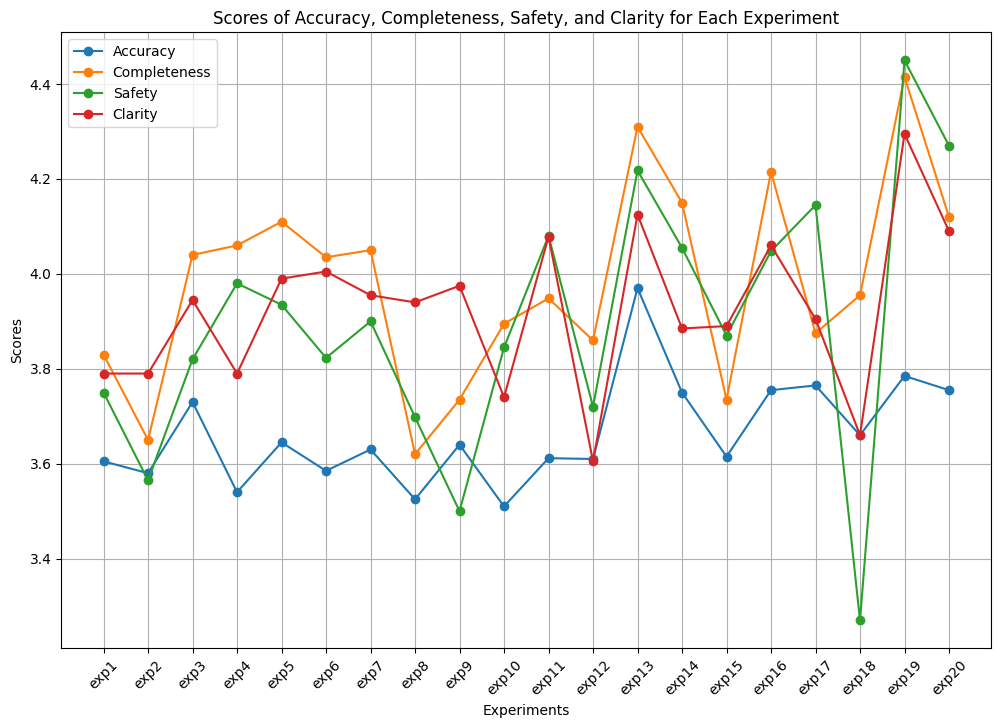

In [1]:
import ast
# import numpy as np
import torch

with open("Phi4_20Exps.txt", "r") as file:
    content = file.read()  # Read the file as a string
    data = ast.literal_eval(content)  # Convert string to a Python object

# print(len(data))  # Now data is a list of dictionaries
# print(type(data))  # Should output <class 'list'>
# phi4nexp1_completeness = []
# phi4nexp2_completeness = []
# phi4nexp3_completeness = []
full_exp_completness = []
full_exp_accuracy = []
full_exp_safety = []
full_exp_clarity = []
for i in data:
    # print(i['Completeness'])
    
    full_exp_completness.append(i['Completeness'])
    full_exp_accuracy.append(i['Accuracy'])
    full_exp_safety.append(i['Clarity'])
    full_exp_clarity.append(i['Safety'])
    # phi4nexp1_completeness.append(i['Completeness'][0])
    # phi4nexp2_completeness.append(i['Completeness'][1])
    # phi4nexp3_completeness.append(i['Completeness'][2])
full_exp_accuracy = torch.tensor(full_exp_accuracy).mean(dim=0)
full_exp_completness = torch.tensor(full_exp_completness).mean(dim=0)
full_exp_safety = torch.tensor(full_exp_safety).mean(dim=0)
full_exp_clarity = torch.tensor(full_exp_clarity).mean(dim=0)

import matplotlib.pyplot as plt

# Define x-axis labels
x_labels = [f'exp{i+1}' for i in range(20)]

# Plot the scores
plt.figure(figsize=(12, 8))

plt.plot(x_labels, full_exp_accuracy.numpy(), label='Accuracy', marker='o')
plt.plot(x_labels, full_exp_completness.numpy(), label='Completeness', marker='o')
plt.plot(x_labels, full_exp_safety.numpy(), label='Safety', marker='o')
plt.plot(x_labels, full_exp_clarity.numpy(), label='Clarity', marker='o')

# Formatting
plt.xlabel('Experiments')
plt.ylabel('Scores')
plt.title('Scores of Accuracy, Completeness, Safety, and Clarity for Each Experiment')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()



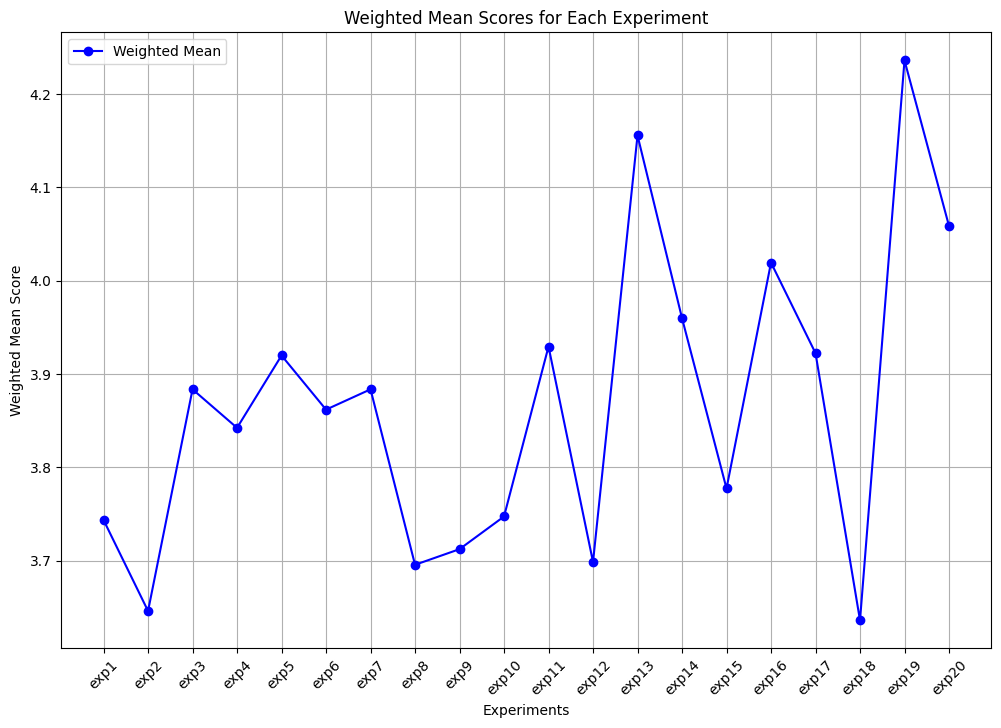

In [5]:
# import torch

# import matplotlib.pyplot as plt

# Stack the tensors
stacked_tensors = torch.stack([full_exp_accuracy, full_exp_completness, full_exp_clarity, full_exp_safety])

# Define weights for each tensor
weights = torch.tensor([1, 1, 1, 1])

# Calculate the weighted mean
weighted_mean = torch.mean(stacked_tensors * weights[:, None], dim=0)

# Plot the weighted mean
x_labels = [f'exp{i+1}' for i in range(20)]

plt.figure(figsize=(12, 8))
plt.plot(x_labels, weighted_mean.numpy(), marker='o', linestyle='-', color='blue', label='Weighted Mean')

# Formatting
plt.xlabel('Experiments')
plt.ylabel('Weighted Mean Score')
plt.title('Weighted Mean Scores for Each Experiment')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
# Save plot
plt.savefig('phi4_20_exps_mean_reward.png')
# Show plot
plt.show()


In [2]:
full_exp_accuracy.shape

torch.Size([20])

In [45]:
full_exp_clarity.mean(dim=0)

tensor([3.7900, 3.7900, 3.9450, 3.7900, 3.9900, 4.0050, 3.9550, 3.9400, 3.9750,
        3.7400, 4.0783, 3.6050, 4.1250, 3.8850, 3.8900, 4.0600, 3.9050, 3.6600,
        4.2950, 4.0900])

In [52]:
import ast

with open("qwenReActPlots.txt", "r") as file:
    content = file.read()  # Read the file as a string
    data = ast.literal_eval(content)  # Convert string to a Python object

print(len(data))  # Now data is a list of dictionaries
# print(type(data))  # Should output <class 'list'>
qwenexp1_completeness = []
qwenexp2_completeness = []
qwenexp3_completeness = []
for i in data:
    # print(i['Completeness'])
    qwenexp1_completeness.append(i['Completeness'][0])
    qwenexp2_completeness.append(i['Completeness'][1])
    qwenexp3_completeness.append(i['Completeness'][2])

10


In [53]:
mean_exp1phi4n = sum(phi4nexp1_completeness)/len(phi4nexp1_completeness)
mean_exp2phi4n = sum(phi4nexp2_completeness)/len(phi4nexp2_completeness)
mean_exp3phi4n = sum(phi4nexp3_completeness)/len(phi4nexp3_completeness)


In [54]:
mean_exp1qwenN = sum(qwenNexp1_completeness)/len(qwenNexp1_completeness)
mean_exp2qwenN = sum(qwenNexp2_completeness)/len(qwenNexp2_completeness)
mean_exp3qwenN = sum(qwenNexp3_completeness)/len(qwenNexp3_completeness)


In [55]:
mean_exp1phi4 = sum(phi4exp1_completeness)/len(phi4exp1_completeness)
mean_exp2phi4 = sum(phi4exp2_completeness)/len(phi4exp2_completeness)
mean_exp3phi4 = sum(phi4exp3_completeness)/len(phi4exp3_completeness)


In [56]:
mean_exp1qwen = sum(qwenexp1_completeness)/len(qwenexp1_completeness)
mean_exp2qwen = sum(qwenexp2_completeness)/len(qwenexp2_completeness)
mean_exp3qwen = sum(qwenexp3_completeness)/len(qwenexp3_completeness)


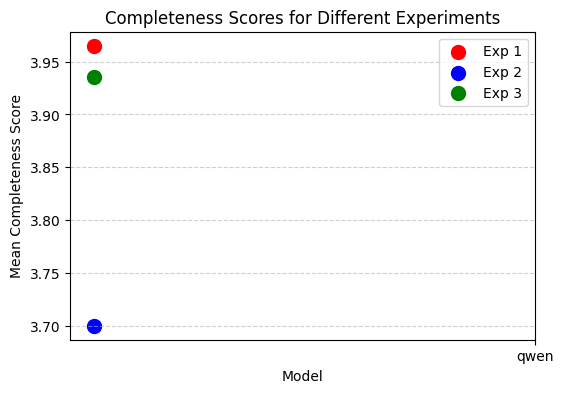

In [ ]:
import matplotlib.pyplot as plt

# Sample completeness data for three experiments


# Compute mean values


# X-axis has a single point labeled "qwen"
x_value = ["phi4"] * 3  # All values share the same x-axis label

# Y-axis: Mean completeness values
y_values = [mean_exp1phi4, mean_exp2phi4, mean_exp3phi4]

# Assign colors for different experiments
colors = ['red', 'blue', 'green']
labels = ['Exp 1', 'Exp 2', 'Exp 3']

# Plot the scatter plot
plt.figure(figsize=(6, 4))
for i in range(3):
    plt.scatter(x_value[i], y_values[i], color=colors[i], label=labels[i], s=100)

# Formatting
plt.xlabel("Model")
plt.ylabel("Mean Completeness Score")
plt.title("Completeness Scores for Different Experiments")
plt.xticks(["qwen"])  # Ensure "qwen" is the only tick on x-axis
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


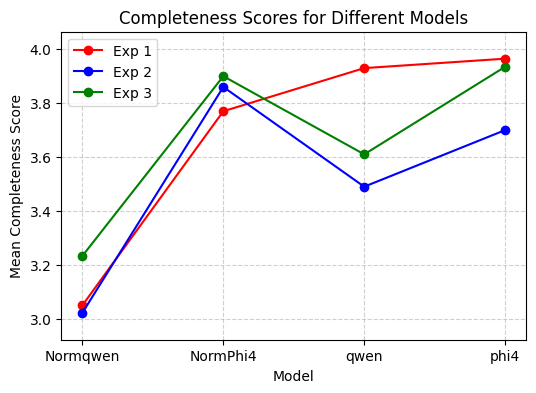

In [57]:
import matplotlib.pyplot as plt

# Mean completeness scores for two models
qwen_completeness = [mean_exp1qwen, mean_exp2qwen, mean_exp3qwen]  # Qwen model scores for Exp1, Exp2, Exp3
phi4_completeness = [mean_exp1phi4, mean_exp2phi4, mean_exp3phi4]  # Phi4 model scores for Exp1, Exp2, Exp3
phi4n_completeness = [mean_exp1phi4n, mean_exp2phi4n, mean_exp3phi4n]  # Phi4 model scores for Exp1, Exp2, Exp3
qwenn_completeness = [mean_exp1qwenN, mean_exp2qwenN, mean_exp3qwenN]  # Phi4 model scores for Exp1, Exp2, Exp3

# X-axis categories (models)
models = ["Normqwen","NormPhi4","qwen", "phi4",]

# Plotting line graph for each experiment
plt.figure(figsize=(6, 4))

# Colors and labels for each experiment
colors = ['red', 'blue', 'green']
labels = ['Exp 1', 'Exp 2', 'Exp 3']

for i in range(3):
    plt.plot(models, [qwenn_completeness[i],phi4n_completeness[i],qwen_completeness[i], phi4_completeness[i]], marker='o', linestyle='-', color=colors[i], label=labels[i])

# Formatting
plt.xlabel("Model")
plt.ylabel("Mean Completeness Score")
plt.title("Completeness Scores for Different Models")
plt.ylim(min(qwen_completeness + phi4_completeness+qwenn_completeness+phi4n_completeness) - 0.1, max(qwen_completeness + phi4_completeness+qwenn_completeness+phi4n_completeness) + 0.1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


In [45]:
with open("qwenReActPlots.txt",'w') as F:
    F.write(str(samples_plot))

In [91]:
import ast

with open("phi4reactplots.txt", "r") as file:
    content = file.read()  # Read the file as a string
    samples_plot_1 = ast.literal_eval(content)  # Convert string to a Python object
print(samples_plot_1)

[{'Accuracy': [3.6, 3.6, 3.7], 'Clarity': [3.9000000000000004, 2.95, 3.9000000000000004], 'Completeness': [4.05, 3.75, 4.05], 'Safety': [3.5, 3.8, 3.5]}, {'Accuracy': [3.6, 3.6, 3.6], 'Clarity': [3.9000000000000004, 3.3, 3.6], 'Completeness': [4.05, 3.8, 3.1999999999999997], 'Safety': [3.5, 3.8, 4.0]}, {'Accuracy': [3.6, 3.6, 3.75], 'Clarity': [3.15, 2.95, 4.1], 'Completeness': [4.05, 3.75, 4.0], 'Safety': [4.15, 3.8, 4.4]}, {'Accuracy': [3.5, 3.6, 3.5], 'Clarity': [3.8000000000000003, 2.95, 3.7], 'Completeness': [3.6999999999999997, 3.75, 3.95], 'Safety': [4.1, 3.8, 3.5]}, {'Accuracy': [3.5, 3.6, 3.6], 'Clarity': [4.4, 3.9, 3.9000000000000004], 'Completeness': [4.3, 3.8, 4.05], 'Safety': [4.2, 4.1, 4.3]}, {'Accuracy': [3.6, 3.6, 3.75], 'Clarity': [3.15, 3.2, 4.0], 'Completeness': [4.05, 3.75, 3.5999999999999996], 'Safety': [3.7, 3.8, 4.3]}, {'Accuracy': [3.6, 3.6, 3.7], 'Clarity': [3.9000000000000004, 3.15, 4.05], 'Completeness': [4.05, 4.05, 4.05], 'Safety': [3.5, 3.9000000000000004,

In [92]:
import ast

with open("qwenReActPlots.txt", "r") as file:
    content = file.read()  # Read the file as a string
    samples_plot_2 = ast.literal_eval(content)  # Convert string to a Python object
print(samples_plot_2)

[{'Accuracy': [3.6, 4.4, 3.6], 'Clarity': [3.15, 3.95, 3.6], 'Completeness': [4.05, 4.1, 3.1999999999999997], 'Safety': [3.9000000000000004, 4.15, 3.8000000000000003]}, {'Accuracy': [3.9, 3.6, 3.6], 'Clarity': [4.25, 2.95, 3.9000000000000004], 'Completeness': [4.3, 3.75, 3.75], 'Safety': [3.2, 3.5999999999999996, 3.3]}, {'Accuracy': [3.6, 3.6, 3.7], 'Clarity': [2.95, 3.9000000000000004, 3.15], 'Completeness': [3.75, 4.05, 4.05], 'Safety': [3.5999999999999996, 3.5, 3.9499999999999997]}, {'Accuracy': [3.6, 3.7, 3.6], 'Clarity': [3.15, 3.3499999999999996, 3.9000000000000004], 'Completeness': [4.05, 4.1, 4.05], 'Safety': [3.35, 3.55, 3.5]}, {'Accuracy': [3.6, 3.8, 4.1], 'Clarity': [3.9000000000000004, 3.55, 4.0], 'Completeness': [4.05, 2.8499999999999996, 3.5999999999999996], 'Safety': [3.5, 3.15, 4.1]}, {'Accuracy': [3.6, 3.6, 3.4], 'Clarity': [3.15, 3.6, 3.6], 'Completeness': [4.05, 3.1999999999999997, 2.95], 'Safety': [3.7, 4.05, 4.05]}, {'Accuracy': [3.6, 3.6, 3.6], 'Clarity': [2.95, 3

C:\Users\rahul_78wxtz2\AppData\Local\Temp\ipykernel_8776\412855505.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)  # Enable color fill


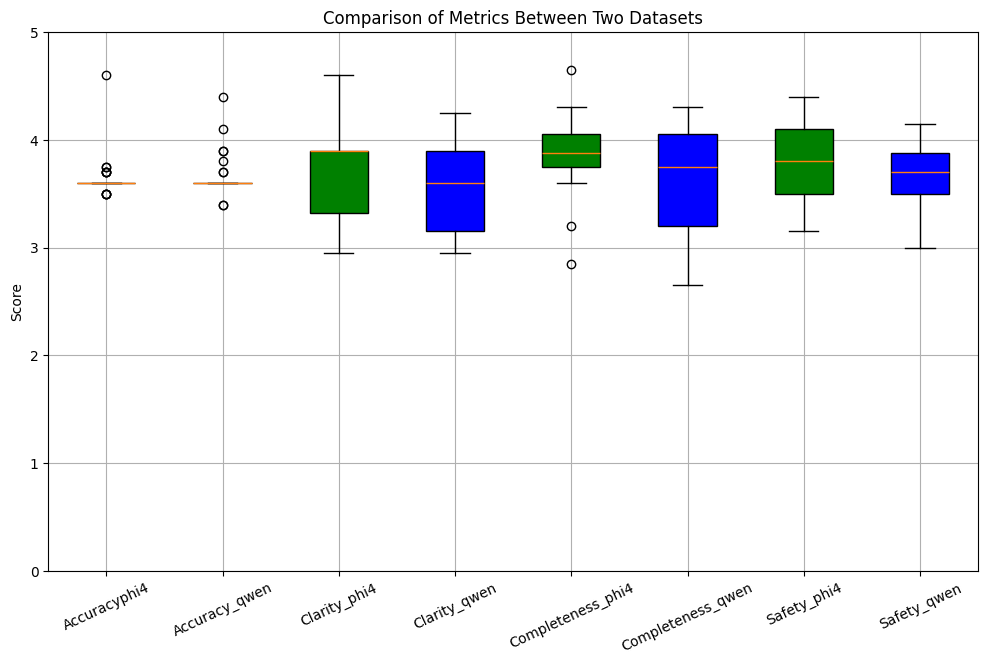

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists for both datasets
accuracy_values_1, clarity_values_1, completeness_values_1, safety_values_1 = [], [], [], []
accuracy_values_2, clarity_values_2, completeness_values_2, safety_values_2 = [], [], [], []

# Extract values from samples_plot (first dataset)
for entry in samples_plot:
    accuracy_values_1.extend(entry['Accuracy'])
    clarity_values_1.extend(entry['Clarity'])
    completeness_values_1.extend(entry['Completeness'])
    safety_values_1.extend(entry['Safety'])

# Extract values from samples_plot_2 (second dataset)
for entry in samples_plot_2:
    accuracy_values_2.extend(entry['Accuracy'])
    clarity_values_2.extend(entry['Clarity'])
    completeness_values_2.extend(entry['Completeness'])
    safety_values_2.extend(entry['Safety'])

# Organize data for the box plot (side-by-side grouping)
data_to_plot = [
    accuracy_values_1, accuracy_values_2,
    clarity_values_1, clarity_values_2,
    completeness_values_1, completeness_values_2,
    safety_values_1, safety_values_2
]

# Labels for the boxplot (grouped)
labels = ['Accuracyphi4', 'Accuracy_qwen', 'Clarity_phi4', 'Clarity_qwen',
          'Completeness_phi4', 'Completeness_qwen', 'Safety_phi4', 'Safety_qwen']

# Create the box plot
colors = ['green', 'blue'] * 4  # Alternates between green and blue

# Create the box plot
plt.figure(figsize=(12, 7))
box = plt.boxplot(data_to_plot, labels=labels, patch_artist=True)  # Enable color fill

# Apply colors to each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Comparison of Metrics Between Two Datasets")
plt.ylabel("Score")
plt.ylim(0, 5)  # Set y-axis range
plt.xticks(rotation=25)  # Rotate labels for better readability
plt.grid(True)

# Show the plot
plt.show()


[{'Accuracy': [3.6, 3.6, 3.7], 'Clarity': [3.9000000000000004, 2.95, 3.9000000000000004], 'Completeness': [4.05, 3.75, 4.05], 'Safety': [3.5, 3.8, 3.5]}, {'Accuracy': [3.6, 3.6, 3.6], 'Clarity': [3.9000000000000004, 3.3, 3.6], 'Completeness': [4.05, 3.8, 3.1999999999999997], 'Safety': [3.5, 3.8, 4.0]}, {'Accuracy': [3.6, 3.6, 3.75], 'Clarity': [3.15, 2.95, 4.1], 'Completeness': [4.05, 3.75, 4.0], 'Safety': [4.15, 3.8, 4.4]}, {'Accuracy': [3.5, 3.6, 3.5], 'Clarity': [3.8000000000000003, 2.95, 3.7], 'Completeness': [3.6999999999999997, 3.75, 3.95], 'Safety': [4.1, 3.8, 3.5]}, {'Accuracy': [3.5, 3.6, 3.6], 'Clarity': [4.4, 3.9, 3.9000000000000004], 'Completeness': [4.3, 3.8, 4.05], 'Safety': [4.2, 4.1, 4.3]}, {'Accuracy': [3.6, 3.6, 3.75], 'Clarity': [3.15, 3.2, 4.0], 'Completeness': [4.05, 3.75, 3.5999999999999996], 'Safety': [3.7, 3.8, 4.3]}, {'Accuracy': [3.6, 3.6, 3.7], 'Clarity': [3.9000000000000004, 3.15, 4.05], 'Completeness': [4.05, 4.05, 4.05], 'Safety': [3.5, 3.9000000000000004,

C:\Users\rahul_78wxtz2\AppData\Local\Temp\ipykernel_8776\869607372.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Accuracy', 'Clarity', 'Completeness', 'Safety'])


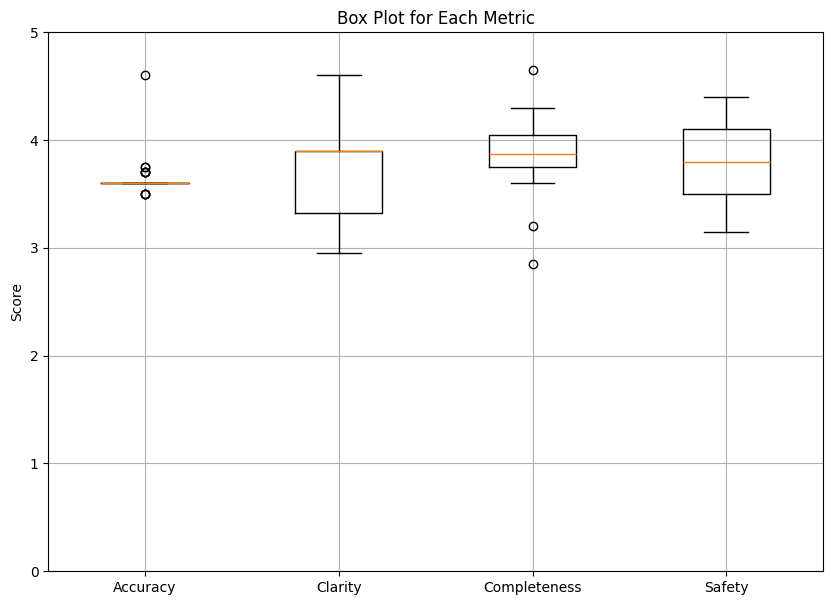

In [95]:
import matplotlib.pyplot as plt
import numpy as np
accuracy_values = []
clarity_values = []
completeness_values = []
safety_values = []
print(samples_plot)
for entry in samples_plot_1:
    accuracy_values.extend(entry['Accuracy'])
    clarity_values.extend(entry['Clarity'])
    completeness_values.extend(entry['Completeness'])
    safety_values.extend(entry['Safety'])

# Organize data for the box plot: one list per metric.
data_to_plot = [accuracy_values, clarity_values, completeness_values, safety_values]

# Create the box plot.
plt.figure(figsize=(10, 7))
plt.boxplot(data_to_plot, labels=['Accuracy', 'Clarity', 'Completeness', 'Safety'])
plt.title("Box Plot for Each Metric")
plt.ylabel("Score")
plt.ylim(0, 5)  # Set y-axis from 0 to 5
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists for both datasets
accuracy_values_1, clarity_values_1, completeness_values_1, safety_values_1 = [], [], [], []
accuracy_values_2, clarity_values_2, completeness_values_2, safety_values_2 = [], [], [], []

# Extract values from samples_plot (first dataset)
for entry in samples_plot:
    accuracy_values_1.extend(entry['Accuracy'])
    clarity_values_1.extend(entry['Clarity'])
    completeness_values_1.extend(entry['Completeness'])
    safety_values_1.extend(entry['Safety'])

# Extract values from samples_plot_2 (second dataset)
for entry in samples_plot_2:
    accuracy_values_2.extend(entry['Accuracy'])
    clarity_values_2.extend(entry['Clarity'])
    completeness_values_2.extend(entry['Completeness'])
    safety_values_2.extend(entry['Safety'])

# Organize data for the box plot (side-by-side grouping)
data_to_plot = [
    accuracy_values_1, accuracy_values_2,
    clarity_values_1, clarity_values_2,
    completeness_values_1, completeness_values_2,
    safety_values_1, safety_values_2
]

# Labels for the boxplot (grouped)
labels = ['Accuracy_1', 'Accuracy_2', 'Clarity_1', 'Clarity_2',
          'Completeness_1', 'Completeness_2', 'Safety_1', 'Safety_2']

# Create the box plot
plt.figure(figsize=(12, 7))
plt.boxplot(data_to_plot, labels=labels)
plt.title("Comparison of Metrics Between Two Datasets")
plt.ylabel("Score")
plt.ylim(0, 5)  # Set y-axis range
plt.xticks(rotation=25)  # Rotate labels for better readability
plt.grid(True)

# Show the plot
plt.show()


C:\Users\rahul_78wxtz2\AppData\Local\Temp\ipykernel_30976\598106487.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot(accuracy_data, labels=['Exp1', 'Exp2', 'Exp3'])
C:\Users\rahul_78wxtz2\AppData\Local\Temp\ipykernel_30976\598106487.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(clarity_data, labels=['Exp1', 'Exp2', 'Exp3'])
C:\Users\rahul_78wxtz2\AppData\Local\Temp\ipykernel_30976\598106487.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(completeness_data, labels=['Exp1', 'Exp2', 'Exp3'])
C:\Users\rahul_78wxtz2\AppData\Local\Temp\ipykernel_30976\

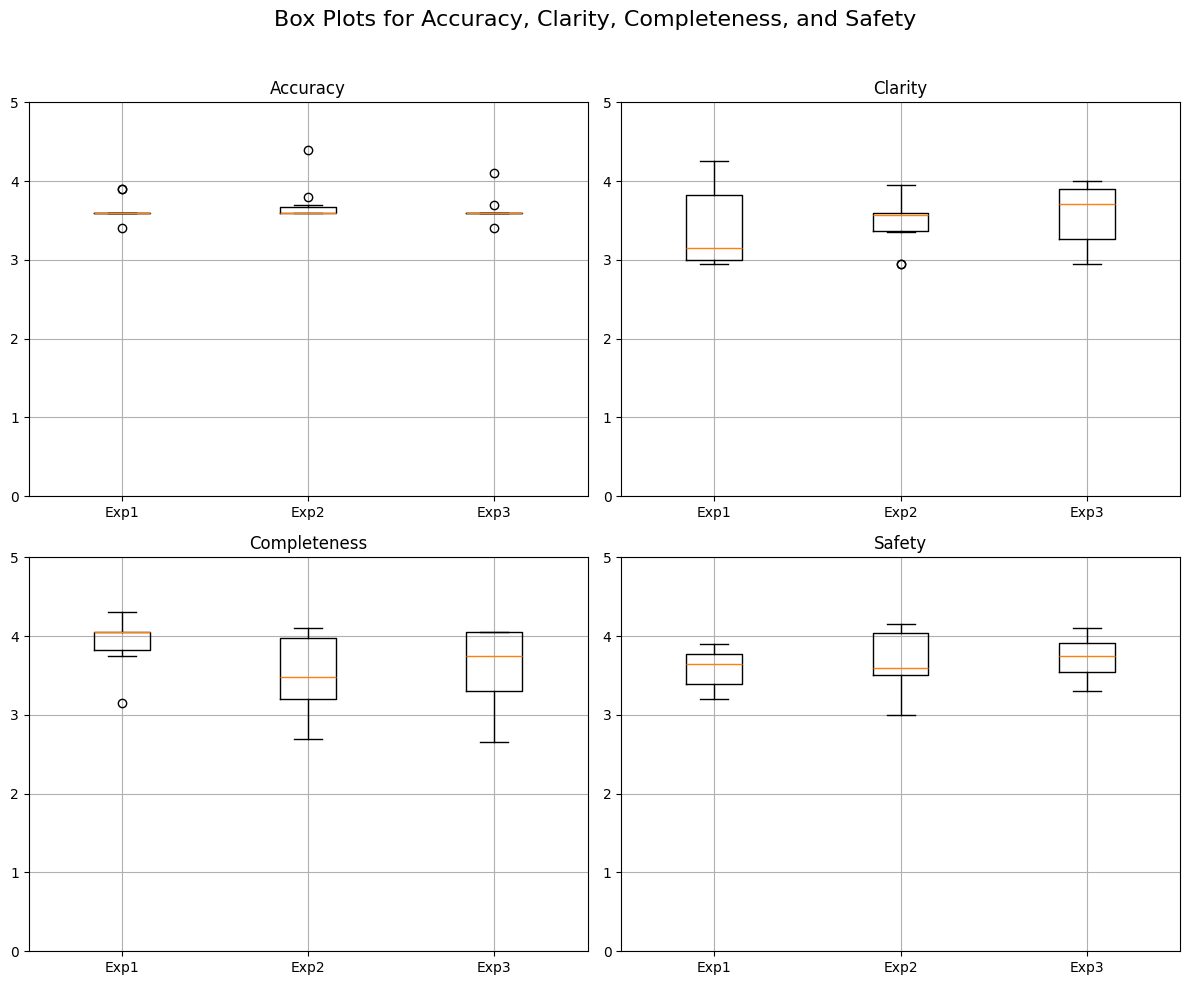

In [42]:
accuracy_exp1, accuracy_exp2, accuracy_exp3 = [], [], []
clarity_exp1, clarity_exp2, clarity_exp3 = [], [], []
completeness_exp1, completeness_exp2, completeness_exp3 = [], [], []
safety_exp1, safety_exp2, safety_exp3 = [], [], []

for entry in samples_plot:
    accuracy_exp1.append(entry['Accuracy'][0])
    accuracy_exp2.append(entry['Accuracy'][1])
    accuracy_exp3.append(entry['Accuracy'][2])

    clarity_exp1.append(entry['Clarity'][0])
    clarity_exp2.append(entry['Clarity'][1])
    clarity_exp3.append(entry['Clarity'][2])

    completeness_exp1.append(entry['Completeness'][0])
    completeness_exp2.append(entry['Completeness'][1])
    completeness_exp3.append(entry['Completeness'][2])

    safety_exp1.append(entry['Safety'][0])
    safety_exp2.append(entry['Safety'][1])
    safety_exp3.append(entry['Safety'][2])

# Data to plot in boxplots
accuracy_data = [accuracy_exp1, accuracy_exp2, accuracy_exp3]
clarity_data = [clarity_exp1, clarity_exp2, clarity_exp3]
completeness_data = [completeness_exp1, completeness_exp2, completeness_exp3]
safety_data = [safety_exp1, safety_exp2, safety_exp3]

# Create 4 subplots (one for each metric)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Box Plots for Accuracy, Clarity, Completeness, and Safety", fontsize=16)

# Accuracy plot
axes[0, 0].boxplot(accuracy_data, labels=['Exp1', 'Exp2', 'Exp3'])
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_ylim(0, 5)
axes[0, 0].grid(True)

# Clarity plot
axes[0, 1].boxplot(clarity_data, labels=['Exp1', 'Exp2', 'Exp3'])
axes[0, 1].set_title("Clarity")
axes[0, 1].set_ylim(0, 5)
axes[0, 1].grid(True)

# Completeness plot
axes[1, 0].boxplot(completeness_data, labels=['Exp1', 'Exp2', 'Exp3'])
axes[1, 0].set_title("Completeness")
axes[1, 0].set_ylim(0, 5)
axes[1, 0].grid(True)

# Safety plot
axes[1, 1].boxplot(safety_data, labels=['Exp1', 'Exp2', 'Exp3'])
axes[1, 1].set_title("Safety")
axes[1, 1].set_ylim(0, 5)
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
num_experiments=20
data = {
    "Accuracy": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)],
    "Completeness": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)],
    "Clarity": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)],
    "Safety": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)]
}
for key,values in data.items():
    print(values)

[{'score1': np.float64(0.26170568373590597), 'score2': np.float64(0.24697879907199982), 'score3': np.float64(0.9062545805210367), 'score4': np.float64(0.2495461998495061), 'score5': np.float64(0.271949726128631)}, {'score1': np.float64(0.7593982624179637), 'score2': np.float64(0.44973984245054), 'score3': np.float64(0.7767105569551812), 'score4': np.float64(0.06536615756438524), 'score5': np.float64(0.4875711936733843)}, {'score1': np.float64(0.03361360018328263), 'score2': np.float64(0.06265320345535452), 'score3': np.float64(0.906437453344411), 'score4': np.float64(0.13924537111759516), 'score5': np.float64(0.5324206822752171)}, {'score1': np.float64(0.41109560260070654), 'score2': np.float64(0.3473433262588427), 'score3': np.float64(0.8998333456872725), 'score4': np.float64(0.0218233967754895), 'score5': np.float64(0.6637896861755891)}, {'score1': np.float64(0.9633944342135504), 'score2': np.float64(0.5601681834618419), 'score3': np.float64(0.9368224620330918), 'score4': np.float64(

In [2]:
import numpy as np

# Simulated data: 20 experiments, each with 5 scores for 4 categories
num_experiments = 20

# Generate random scores between 0 and 1
np.random.seed(42)  # For reproducibility
data = {
    "Accuracy": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)],
    "Completeness": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)],
    "Clarity": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)],
    "Safety": [dict(zip(["score1", "score2", "score3", "score4", "score5"], np.random.rand(5))) for _ in range(num_experiments)]
}

# Weights for scores
weights = np.array([1, 2, 3, 4, 5])

# Dictionary to store weighted scores
weighted_scores = {}

# Compute weighted scores for each category
for category, experiments in data.items():
    weighted_scores[category] = []
    
    for scores in experiments:
        score_values = np.array([scores[f"score{i}"] for i in range(1, 6)])  # Extract scores
        weighted_avg = np.dot(weights, score_values) / 5  # Compute weighted average
        weighted_scores[category].append(weighted_avg)

# Print results
import pprint
pprint.pprint(weighted_scores)


{'Accuracy': [np.float64(1.5293355392203478),
              np.float64(1.763102623590094),
              np.float64(1.243242679953933),
              np.float64(1.1100168132455788),
              np.float64(1.1026143711784129),
              np.float64(1.0658274359997453),
              np.float64(1.9534900385235978),
              np.float64(1.3296671606457977),
              np.float64(1.2293478269456375),
              np.float64(1.191452379013398),
              np.float64(2.3814312789890755),
              np.float64(0.6988737271685731),
              np.float64(1.2498547471808643),
              np.float64(1.6927545466183127),
              np.float64(1.5964749833586462),
              np.float64(0.9013780056835777),
              np.float64(0.9823077527622125),
              np.float64(1.9213987377767132),
              np.float64(1.9856767312571548),
              np.float64(0.6926035904293861)],
 'Clarity': [np.float64(1.5843119541668986),
             np.float64(0.60538640742

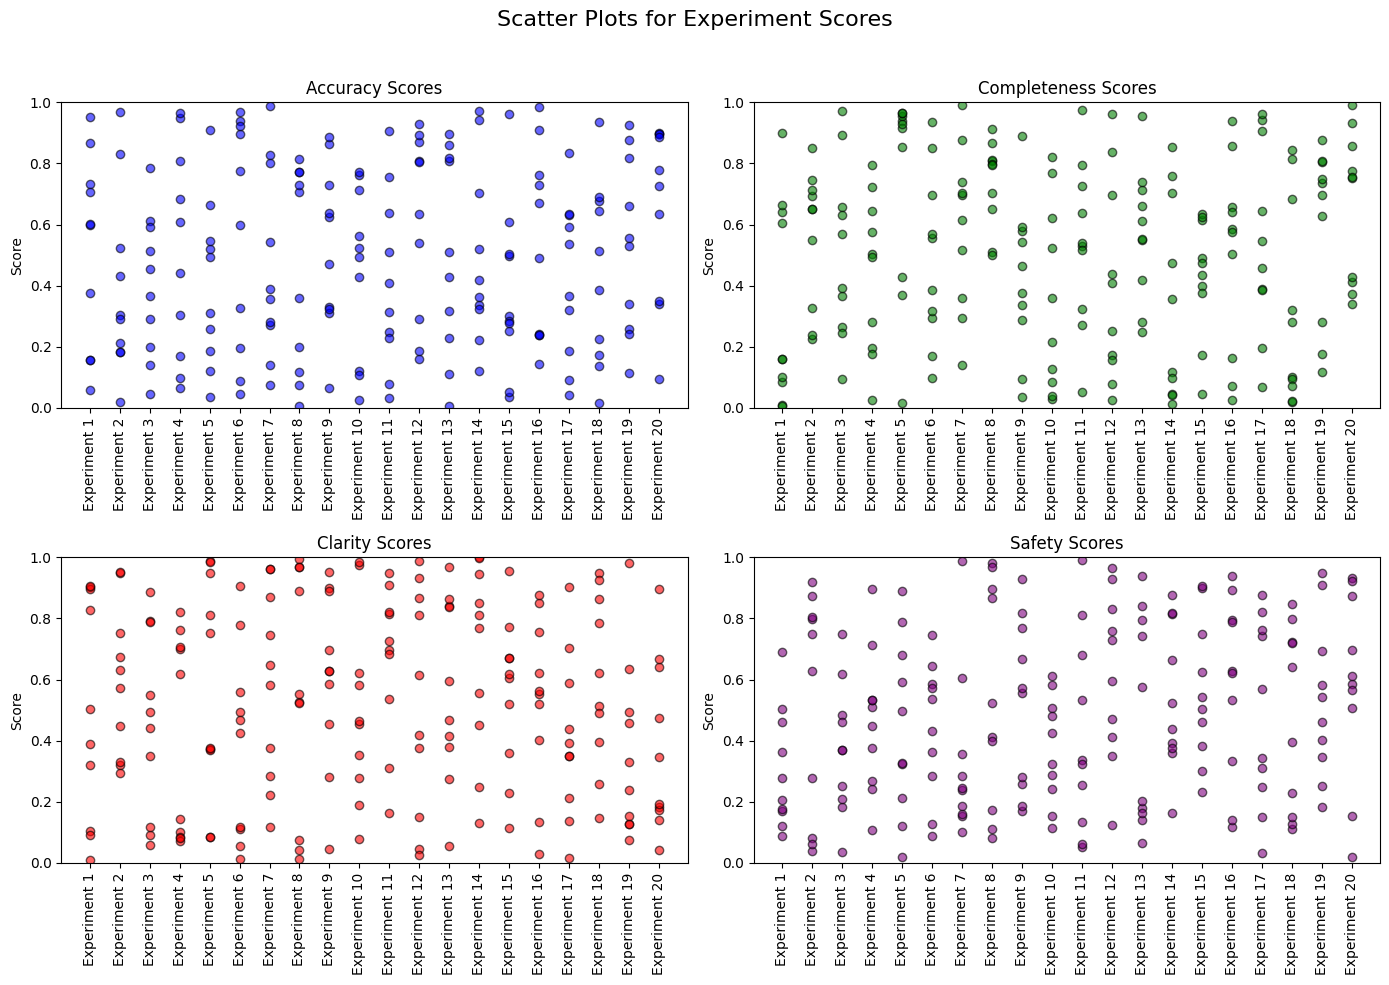

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data: 20 experiments, each with 10 samples having 4 scores
num_experiments = 20
num_samples = 10

# Randomly generate scores for 4 categories
np.random.seed(42)  # For reproducibility
accuracy_scores = np.random.rand(num_experiments, num_samples)
completeness_scores = np.random.rand(num_experiments, num_samples)
clarity_scores = np.random.rand(num_experiments, num_samples)
safety_scores = np.random.rand(num_experiments, num_samples)

# Define experiment labels
experiment_labels = [f"Experiment {i+1}" for i in range(num_experiments)]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Scatter Plots for Experiment Scores", fontsize=16)

# Function to create scatter plots
def plot_scatter(ax, scores, title, color):
    for i in range(num_experiments):
        ax.scatter([i] * num_samples, scores[i], color=color, alpha=0.6, edgecolors='black')
    ax.set_title(title)
    ax.set_xticks(range(num_experiments))
    ax.set_xticklabels(experiment_labels, rotation=90)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")

# Plot each metric
plot_scatter(axes[0, 0], accuracy_scores, "Accuracy Scores", "blue")
plot_scatter(axes[0, 1], completeness_scores, "Completeness Scores", "green")
plot_scatter(axes[1, 0], clarity_scores, "Clarity Scores", "red")
plot_scatter(axes[1, 1], safety_scores, "Safety Scores", "purple")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Old Eval method 

In [ ]:
import json
import re
import logging
from typing import Dict, Optional
import ollama
import os
os.environ["OLLAMA_HOST"] = "192.168.23.138:11439"
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")
logger = logging.getLogger(__name__)
def load_json(filepath: str) -> Dict:
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        logger.error(f"File not found: {filepath}")
        raise
    except json.JSONDecodeError:
        logger.error(f"Invalid JSON in file: {filepath}")
        raise
def extract_json_from_response(response_text: str) -> Optional[Dict]:
    try:
        json_match = re.search(r"\{.*\}", response_text, re.DOTALL)  # Extracts only JSON part
        if json_match:
            return json.loads(json_match.group())
        else:
            logger.error("No valid JSON found in response.")
            return None
    except json.JSONDecodeError as e:
        logger.error(f"JSON parsing error: {e}")
        return None

def generate_evaluation_prompt(ground_truth: Dict, test_procedure: str) -> str:
    return f"""
You are an expert evaluator assessing the accuracy, completeness, clarity, and safety of a scientific experiment procedure.

### **Task**
Compare the **Test Procedure** against the **Ground Truth** and evaluate it across four key dimensions. Provide a **probability distribution over scores [1,2,3,4,5]** for each category.

### **Evaluation Criteria**
1. **Accuracy**: Are the components and steps correct?
2. **Completeness**: Are all critical steps present?
3. **Clarity**: Is the procedure easy to follow?
4. **Safety**: Are safety precautions included?

### **Response Format (Strict JSON)**
```json
{{ scores:
    "Accuracy": {{ "1": p1, "2": p2, "3": p3, "4": p4, "5": p5 }},
    "Completeness": {{ "1": p1, "2": p2, "3": p3, "4": p4, "5": p5 }},
    "Clarity": {{ "1": p1, "2": p2, "3": p3, "4": p4, "5": p5 }},
    "Safety": {{ "1": p1, "2": p2, "3": p3, "4": p4, "5": p5 }}
}}
Each probability value must be between 0 and 1 and sum to 1.

### **Ground Truth**
{json.dumps(ground_truth, indent=4)}

### **Test Procedure**
{test_procedure}
"""
def evaluate_experiment(title: str, ground_truth: Dict, test_procedure: str) -> Optional[Dict]:
    prompt = generate_evaluation_prompt(ground_truth, test_procedure)

    try:
        response = ollama.chat(
            model="phi4",
            messages=[{"role": "user", "content": prompt}],
            options={"timeout": 60}
        )

        # Debug: Print the raw response to see what the model is returning
        model_output = response['message']['content'].strip()
        print(f"\n🔹 **Raw Response for {title}:**\n{model_output}\n")

        return extract_json_from_response(model_output)  # Extract only valid JSON

    except Exception as e:
        logger.error(f"Error evaluating {title}: {e}")
        return None

def calculate_reward(evaluation_result: Dict) -> float:
    """
    Calculate a reward based on evaluation scores.
    """
    weights = {
        "Accuracy": 0.3,
        "Completeness": 0.25,
        "Clarity": 0.25,
        "Safety": 0.2
    }

    if not isinstance(evaluation_result, dict):
        logger.error("Invalid evaluation result format. Expected a dictionary.")
        return 0

    total_reward = 0
    try:
        for category, scores in evaluation_result.items():
            if not isinstance(scores, dict):
                logger.error(f"Invalid score structure for category: {category}")
                continue

            weighted_score = sum(int(score) * prob for score, prob in scores.items())
            total_reward += weighted_score * weights.get(category, 0.25)

        return min(max(total_reward, 0), 5)  # Normalize reward between 0-5

    except Exception as e:
        logger.error(f"Reward calculation error: {e}")
        return 0

def run_evaluation(ground_truth_path: str, results_path: str, output_path: str):
    ground_truth_data = load_json(ground_truth_path)
    llm_generated_results = load_json(results_path)
    ground_truth_dict = {exp["title"]: exp for exp in ground_truth_data["experiments"]}
    evaluation_results = {}
    rewards = {}
    for title, test_procedure in llm_generated_results.items():
        ground_truth = ground_truth_dict.get(title)

        if ground_truth:
            logger.info(f"Evaluating: {title}")
            result = evaluate_experiment(title, ground_truth, test_procedure)

            if result:
                evaluation_results[title] = result
                rewards[title] = calculate_reward(result)
    output_data = {
        "evaluations": evaluation_results,
        "rewards": rewards
    }
    with open(output_path, "w", encoding="utf-8") as file:
        json.dump(output_data, file, indent=4, ensure_ascii=False)

    logger.info(f"Evaluation complete! Results saved to '{output_path}'.")
run_evaluation(
    ground_truth_path="experiments.json",
    results_path="output.json",
    output_path="evaluation_results.json"
)

2025-02-10 13:30:13,981 - INFO: Evaluating: Series and Parallel Circuits
2025-02-10 13:30:34,138 - INFO: HTTP Request: POST http://192.168.23.138:11439/api/chat "HTTP/1.1 200 OK"
2025-02-10 13:30:34,141 - ERROR: JSON parsing error: Extra data: line 4 column 1 (char 73)
2025-02-10 13:30:34,143 - INFO: Evaluating: Kirchhoff's Voltage and Current Laws (KVL and KCL)



🔹 **Raw Response for Series and Parallel Circuits:**
To evaluate the test procedure against the ground truth, we'll analyze each dimension: accuracy, completeness, clarity, and safety. We'll provide a probability distribution over scores [1,2,3,4,5] for each category.

### Evaluation

#### 1. Accuracy
- **Ground Truth**: Specifies using a DC power supply, ammeter, and voltmeter for measurements.
- **Test Procedure**: Uses a multimeter for both voltage and current measurements. This is acceptable as modern multimeters can perform these functions.
- **Analysis**: The steps for measuring in series and parallel circuits are correctly outlined, including the calculation of equivalent resistance using Ohm's Law.

**Probability Distribution:**
```json
{
    "Accuracy": { "1": 0.0, "2": 0.0, "3": 0.1, "4": 0.5, "5": 0.4 }
}
```

#### 2. Completeness
- **Ground Truth**: Includes specific steps for measuring voltage and current in both series and parallel circuits.
- **Test Procedure**: Covers 

2025-02-10 13:30:44,832 - INFO: HTTP Request: POST http://192.168.23.138:11439/api/chat "HTTP/1.1 200 OK"
2025-02-10 13:30:44,836 - ERROR: JSON parsing error: Extra data: line 4 column 1 (char 78)
2025-02-10 13:30:44,837 - INFO: Evaluating: Ohm's Law Verification



🔹 **Raw Response for Kirchhoff's Voltage and Current Laws (KVL and KCL):**
To evaluate the test procedure against the ground truth, we will analyze it across four dimensions: Accuracy, Completeness, Clarity, and Safety. Each dimension will be scored on a probability distribution over scores [1,2,3,4,5].

### **Evaluation**

#### 1. **Accuracy**
- The test procedure correctly includes steps for both KVL and KCL.
- It uses appropriate tools like a multimeter with voltmeter and ammeter functions.
- Some discrepancies include not specifying exact resistor values or power supply details as in the ground truth.

**Probability Distribution:**
```json
{
    "Accuracy": { "1": 0.05, "2": 0.10, "3": 0.25, "4": 0.40, "5": 0.20 }
}
```

#### 2. **Completeness**
- The test procedure covers the essential steps for setting up and measuring circuits using KVL and KCL.
- It includes safety precautions which are not explicitly mentioned in the ground truth.
- However, it lacks specific instructions for

2025-02-10 13:30:56,480 - INFO: HTTP Request: POST http://192.168.23.138:11439/api/chat "HTTP/1.1 200 OK"
2025-02-10 13:30:56,483 - ERROR: JSON parsing error: Extra data: line 1 column 58 (char 57)
2025-02-10 13:30:56,488 - INFO: Evaluation complete! Results saved to 'evaluation_results.json'.



🔹 **Raw Response for Ohm's Law Verification:**
To evaluate the Test Procedure against the Ground Truth across the dimensions of Accuracy, Completeness, Clarity, and Safety, we need to analyze each aspect in detail:

### **Accuracy**
- **Test Procedure**: Correctly describes setting up a circuit with resistors, ammeter, voltmeter, and power supply. The steps align well with verifying Ohm's Law.
- **Ground Truth**: Emphasizes series connection of components and specific measurement techniques.
- **Comparison**: Both include correct component connections and measurement steps. However, the Ground Truth specifies using a "known value" resistor initially, while the Test Procedure suggests starting with the lowest resistance without specifying it must be known.

**Probability Distribution for Accuracy:**
- `{ "1": 0.05, "2": 0.10, "3": 0.25, "4": 0.40, "5": 0.20 }`

### **Completeness**
- **Test Procedure**: Covers circuit setup, data collection, and analysis but lacks explicit mention of i

In [5]:
import json 
with open("experiments_generated_phi4.json", "r", encoding="utf-8") as json_file:
    existing_data = json.load(json_file)

exps = existing_data["experiments"]


In [6]:
len(exps)

20

In [1]:
import json

# Read the input JSON file
with open('experiments_generated_phi4.json', 'r') as file:
    data = json.load(file)

# Function to format an experiment into the desired string
def format_experiment(experiment):
    exp_name = experiment["title"] if experiment['title'].find("Experiment Plan:")==-1 else experiment["title"].split("Experiment Plan:")[1]

    formatted = f"Experiment Name: {exp_name}\n\n"
    formatted += f"Objective: {experiment['objective']}\n\n"
    formatted += "Materials Required:\n"
    for i, material in enumerate(experiment['materials'], 1):
        formatted += f"{i}. {material}\n"
    
    # Handle procedure, analysis, etc.
    if 'procedure' in experiment:
        formatted += "\nStep-by-Step Procedure:\n"
        procedure = experiment['procedure']
        
        # Handle different procedure structures
        if isinstance(procedure, dict):
            for step, items in procedure.items():
                if isinstance(items, list):
                    for i, item in enumerate(items, 1):
                        formatted += f"{i}. {item}\n"
                elif isinstance(items, dict):
                    for sub_step, sub_items in items.items():
                        formatted += f"\n{sub_step}:\n"
                        for i, sub_item in enumerate(sub_items, 1):
                            formatted += f"{i}. {sub_item}\n"
    
    # Add other sections like analysis, expected results, and conclusion
    if 'analysis' in experiment:
        formatted += "\nAnalysis:\n"
        for i, analysis in enumerate(experiment['analysis'], 1):
            formatted += f"{i}. {analysis}\n"
    
    return formatted

# Create the new JSON structure
new_data = {}
for experiment in data['experiments']:
    new_data[experiment['title']] = format_experiment(experiment)

# Write the new data to a JSON file
with open('output.json', 'w') as file:
    json.dump(new_data, file, indent=2)

2025-02-10 13:30:13,981 - INFO: Evaluating: Series and Parallel Circuits
2025-02-10 13:30:34,138 - INFO: HTTP Request: POST http://192.168.23.138:11439/api/chat "HTTP/1.1 200 OK"
2025-02-10 13:30:34,141 - ERROR: JSON parsing error: Extra data: line 4 column 1 (char 73)
2025-02-10 13:30:34,143 - INFO: Evaluating: Kirchhoff's Voltage and Current Laws (KVL and KCL)

🔹 **Raw Response for Series and Parallel Circuits:**
To evaluate the test procedure against the ground truth, we'll analyze each dimension: accuracy, completeness, clarity, and safety. We'll provide a probability distribution over scores [1,2,3,4,5] for each category.

### Evaluation

#### 1. Accuracy
- **Ground Truth**: Specifies using a DC power supply, ammeter, and voltmeter for measurements.
- **Test Procedure**: Uses a multimeter for both voltage and current measurements. This is acceptable as modern multimeters can perform these functions.
- **Analysis**: The steps for measuring in series and parallel circuits are correctly outlined, including the calculation of equivalent resistance using Ohm's Law.

**Probability Distribution:**
```json
{
    "Accuracy": { "1": 0.0, "2": 0.0, "3": 0.1, "4": 0.5, "5": 0.4 }
}
```

#### 2. Completeness
- **Ground Truth**: Includes specific steps for measuring voltage and current in both series and parallel circuits.
- **Test Procedure**: Covers all critical steps but does not explicitly mention measuring total voltage across the series combination or voltage across each resistor in parallel.
- **Analysis**: The procedure is mostly complete, with minor omissions.

**Probability Distribution:**
```json
{
    "Completeness": { "1": 0.0, "2": 0.1, "3": 0.4, "4": 0.5, "5": 0.0 }
}
```

#### 3. Clarity
- **Ground Truth**: Clearly outlines steps for series and parallel configurations.
- **Test Procedure**: Provides detailed instructions with a clear step-by-step approach, including safety guidelines.
- **Analysis**: The procedure is easy to follow and well-structured.

**Probability Distribution:**
```json
{
    "Clarity": { "1": 0.0, "2": 0.0, "3": 0.1, "4": 0.6, "5": 0.3 }
}
```

#### 4. Safety
- **Ground Truth**: Does not mention specific safety precautions.
- **Test Procedure**: Includes comprehensive safety guidelines such as using insulated gloves and goggles, ensuring secure connections, and working in a dry environment.
- **Analysis**: The test procedure excels in safety considerations.

**Probability Distribution:**
```json
{
    "Safety": { "1": 0.0, "2": 0.0, "3": 0.0, "4": 0.2, "5": 0.8 }
}
```

### Final JSON Response

```json
{
    "Accuracy": { "1": 0.0, "2": 0.0, "3": 0.1, "4": 0.5, "5": 0.4 },
    "Completeness": { "1": 0.0, "2": 0.1, "3": 0.4, "4": 0.5, "5": 0.0 },
    "Clarity": { "1": 0.0, "2": 0.0, "3": 0.1, "4": 0.6, "5": 0.3 },
    "Safety": { "1": 0.0, "2": 0.0, "3": 0.0, "4": 0.2, "5": 0.8 }
}
```

2025-02-10 13:30:44,832 - INFO: HTTP Request: POST http://192.168.23.138:11439/api/chat "HTTP/1.1 200 OK"
2025-02-10 13:30:44,836 - ERROR: JSON parsing error: Extra data: line 4 column 1 (char 78)
2025-02-10 13:30:44,837 - INFO: Evaluating: Ohm's Law Verification

🔹 **Raw Response for Kirchhoff's Voltage and Current Laws (KVL and KCL):**
To evaluate the test procedure against the ground truth, we will analyze it across four dimensions: Accuracy, Completeness, Clarity, and Safety. Each dimension will be scored on a probability distribution over scores [1,2,3,4,5].

### **Evaluation**

#### 1. **Accuracy**
- The test procedure correctly includes steps for both KVL and KCL.
- It uses appropriate tools like a multimeter with voltmeter and ammeter functions.
- Some discrepancies include not specifying exact resistor values or power supply details as in the ground truth.

**Probability Distribution:**
```json
{
    "Accuracy": { "1": 0.05, "2": 0.10, "3": 0.25, "4": 0.40, "5": 0.20 }
}
```

#### 2. **Completeness**
- The test procedure covers the essential steps for setting up and measuring circuits using KVL and KCL.
- It includes safety precautions which are not explicitly mentioned in the ground truth.
- However, it lacks specific instructions for verifying the conservation of charge and energy, as outlined in the analysis section of the ground truth.

**Probability Distribution:**
```json
{
    "Completeness": { "1": 0.10, "2": 0.20, "3": 0.30, "4": 0.30, "5": 0.10 }
}
```

#### 3. **Clarity**
- The procedure is clear and easy to follow with step-by-step instructions.
- Safety precautions are explicitly stated, enhancing understanding and execution.

**Probability Distribution:**
```json
{
    "Clarity": { "1": 0.05, "2": 0.10, "3": 0.15, "4": 0.50, "5": 0.20 }
}
```

#### 4. **Safety**
- The test procedure includes comprehensive safety measures such as using low-voltage sources and wearing insulated gloves.
- It emphasizes secure connections and keeping conductive liquids away from the setup.

**Probability Distribution:**
```json
{
    "Safety": { "1": 0.00, "2": 0.05, "3": 0.10, "4": 0.35, "5": 0.50 }
}
```

### **Overall Evaluation**

The test procedure is generally accurate and clear, with strong emphasis on safety, though it could be more complete in terms of analysis verification steps.

```json
{
    "Accuracy": { "1": 0.05, "2": 0.10, "3": 0.25, "4": 0.40, "5": 0.20 },
    "Completeness": { "1": 0.10, "2": 0.20, "3": 0.30, "4": 0.30, "5": 0.10 },
    "Clarity": { "1": 0.05, "2": 0.10, "3": 0.15, "4": 0.50, "5": 0.20 },
    "Safety": { "1": 0.00, "2": 0.05, "3": 0.10, "4": 0.35, "5": 0.50 }
}
```

2025-02-10 13:30:56,480 - INFO: HTTP Request: POST http://192.168.23.138:11439/api/chat "HTTP/1.1 200 OK"
2025-02-10 13:30:56,483 - ERROR: JSON parsing error: Extra data: line 1 column 58 (char 57)
2025-02-10 13:30:56,488 - INFO: Evaluation complete! Results saved to 'evaluation_results.json'.

🔹 **Raw Response for Ohm's Law Verification:**
To evaluate the Test Procedure against the Ground Truth across the dimensions of Accuracy, Completeness, Clarity, and Safety, we need to analyze each aspect in detail:

### **Accuracy**
- **Test Procedure**: Correctly describes setting up a circuit with resistors, ammeter, voltmeter, and power supply. The steps align well with verifying Ohm's Law.
- **Ground Truth**: Emphasizes series connection of components and specific measurement techniques.
- **Comparison**: Both include correct component connections and measurement steps. However, the Ground Truth specifies using a "known value" resistor initially, while the Test Procedure suggests starting with the lowest resistance without specifying it must be known.

**Probability Distribution for Accuracy:**
- `{ "1": 0.05, "2": 0.10, "3": 0.25, "4": 0.40, "5": 0.20 }`

### **Completeness**
- **Test Procedure**: Covers circuit setup, data collection, and analysis but lacks explicit mention of incrementing voltage steps.
- **Ground Truth**: Includes detailed steps for initial settings, incremental voltage increase, and repeated measurements.
- **Comparison**: The Test Procedure omits the step-by-step voltage increase and multiple measurement repetitions.

**Probability Distribution for Completeness:**
- `{ "1": 0.10, "2": 0.30, "3": 0.40, "4": 0.15, "5": 0.05 }`

### **Clarity**
- **Test Procedure**: Provides a clear step-by-step guide with specific instructions for setup and measurement.
- **Ground Truth**: Also presents steps clearly but includes more explicit details on initial settings and repetition.
- **Comparison**: Both are easy to follow; however, the Ground Truth offers slightly more clarity with detailed sub-steps.

**Probability Distribution for Clarity:**
- `{ "1": 0.05, "2": 0.10, "3": 0.35, "4": 0.40, "5": 0.10 }`

### **Safety**
- **Test Procedure**: Mentions safety equipment (gloves and goggles) but does not provide specific safety instructions during the experiment.
- **Ground Truth**: Does not mention any safety precautions.
- **Comparison**: The Test Procedure includes a basic level of safety consideration, which is an improvement over the Ground Truth.

**Probability Distribution for Safety:**
- `{ "1": 0.10, "2": 0.20, "3": 0.30, "4": 0.30, "5": 0.10 }`

### **Final JSON Response**

```json
{
    "Accuracy": { "1": 0.05, "2": 0.10, "3": 0.25, "4": 0.40, "5": 0.20 },
    "Completeness": { "1": 0.10, "2": 0.30, "3": 0.40, "4": 0.15, "5": 0.05 },
    "Clarity": { "1": 0.05, "2": 0.10, "3": 0.35, "4": 0.40, "5": 0.10 },
    "Safety": { "1": 0.10, "2": 0.20, "3": 0.30, "4": 0.30, "5": 0.10 }
}
```

This evaluation reflects that while the Test Procedure is largely accurate and clear, it lacks some completeness in detailing measurement increments and repetitions, and offers a basic level of safety consideration.

In [51]:
import os

def list_files_in_directory(directory):
    try:
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")

In [52]:
dir = "exps_phi4"
fnames = [i for i in list_files_in_directory(dir) if i[-1] == 'n']

In [53]:
fnames

['phi4Outputs_0.json',
 'phi4Outputs_1.json',
 'phi4Outputs_2.json',
 'phi4Outputs_3.json',
 'phi4Outputs_4.json',
 'phi4Outputs_5.json',
 'phi4Outputs_6.json',
 'phi4Outputs_7.json',
 'phi4Outputs_8.json',
 'phi4Outputs_9.json']

In [7]:
import json
with open(dir+"/"+fnames[0],'r') as F:
    json_file = json.load(F)

In [54]:
import pprint
six_exps = experiment_name
six_exps = six_exps[::-1]
fin_dr = "reformatted_phi4_exps"
for phi4exps in fnames:
    exps_dict = {}
    with open(dir+"/"+phi4exps,'r') as F:
        json_file = json.load(F)['experiments']
    for title,single_exps in zip(six_exps, json_file):
        exps_dict[title] = single_exps
    with open(fin_dr+"/"+phi4exps,'w') as f:
        json.dump(exps_dict,f,indent=4)

In [ ]:
import ast

with open("qwenReActPlots.txt", "r") as file:
    content = file.read()  # Read the file as a string
    data = ast.literal_eval(content)  # Convert string to a Python object

print(len(data))  # Now data is a list of dictionaries
# print(type(data))  # Should output <class 'list'>
qwenexp1_completeness = []
qwenexp2_completeness = []
qwenexp3_completeness = []
for i in data:
    # print(i['Completeness'])
    qwenexp1_completeness.append(i['Completeness'][0])
    qwenexp2_completeness.append(i['Completeness'][1])
    qwenexp3_completeness.append(i['Completeness'][2])

In [58]:
plot_names = ["qwennormalplot.txt","qwenReActPlots.txt","phi4normalplots.txt","phi4reactplots.txt"]
plot_datas = []
for datafiles in plot_names:
    with open(datafiles,'r') as file:
        content = file.read()
        dataplots = ast.literal_eval(content)
        plot_datas.append(dataplots)




In [71]:
accuracy = []
completeness = []
safety = []
clarity = []
for i in plot_datas[0]:
    accuracy.append(i['Accuracy'])
    completeness.append(i['Completeness'])
    safety.append(i['Safety'])
    clarity.append(i['Clarity'])

flattened_safety = [item for sublist in safety for item in sublist]
flattened_clarity = [item for sublist in clarity for item in sublist]
flattened_accuracy = [item for sublist in accuracy for item in sublist]
flattened_completeness = [item for sublist in completeness for item in sublist]
finaccuracy = sum(flattened_accuracy)/len(flattened_accuracy)
fincompleteness = sum(flattened_completeness)/len(flattened_completeness)
finclarity = sum(flattened_clarity)/len(flattened_clarity)
finsafety = sum(flattened_safety)/len(flattened_safety)


In [72]:
print(finaccuracy,fincompleteness,finclarity,finsafety)

3.531481481481481 3.1018518518518516 3.5333333333333337 3.287037037037037


In [ ]:
phi4React = [3.643333333333333,3.8666666666666667,3.7183333333333333,3.8366666666666664]
phi4Normal = [3.52, 3.8433333333333333, 3.8200000000000003, 3.9366666666666665]
qwen_react = [3.6633333333333336, 3.6766666666666667, 3.501, 3.6616666666666666]
qwen_normal = [3.531481481481481 3.1018518518518516 3.5333333333333337 3.287037037037037]

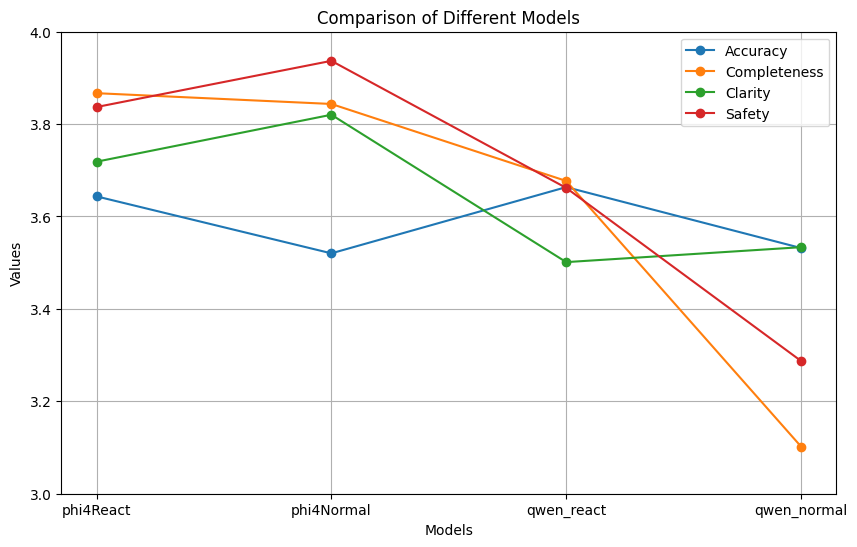

In [76]:
import matplotlib.pyplot as plt

# Data
phi4React = [3.643333333333333, 3.8666666666666667, 3.7183333333333333, 3.8366666666666664]
phi4Normal = [3.52, 3.8433333333333333, 3.8200000000000003, 3.9366666666666665]
qwen_react = [3.6633333333333336, 3.6766666666666667, 3.501, 3.6616666666666666]
qwen_normal = [3.531481481481481, 3.1018518518518516, 3.5333333333333337, 3.287037037037037]

# Legends
legends = ['Accuracy', 'Completeness', 'Clarity', 'Safety']

# Transpose the data
data = [phi4React, phi4Normal, qwen_react, qwen_normal]
data_transposed = list(zip(*data))

# X-axis labels
x_labels = ['phi4React', 'phi4Normal', 'qwen_react', 'qwen_normal']
x = range(len(x_labels))

# Plotting
plt.figure(figsize=(10, 6))

for i, metric in enumerate(data_transposed):
    plt.plot(x, metric, marker='o', label=legends[i])

plt.xticks(x, x_labels)
plt.ylim(3, 4)
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Comparison of Different Models')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

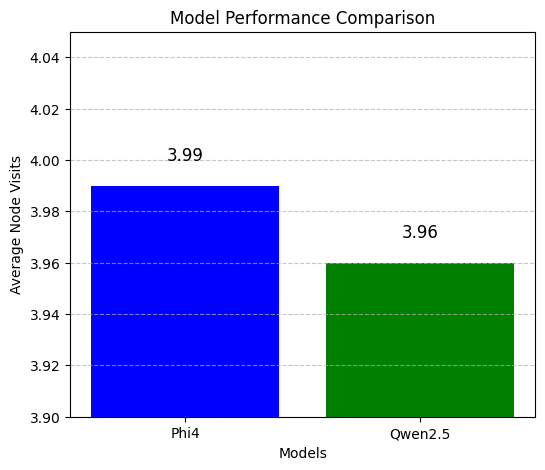

In [96]:
import matplotlib.pyplot as plt

# Data
models = ['Phi4', 'Qwen2.5']
values = [3.99, 3.96]

# Create bar plot
plt.figure(figsize=(6, 5))
plt.bar(models, values, color=['blue', 'green'])

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Average Node Visits")
plt.title("Model Performance Comparison")

# Show value labels on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(v), ha='center', fontsize=12)

# Show the plot
plt.ylim(3.9, 4.05)  # Adjust y-axis range for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
